In [28]:
%load_ext autoreload
%autoreload 2

from src import (
    datahandler as dah,
    model as mod,
    graphs as gra,
    visualize as vis,
    analysis as ana,
)

import pandas as pd
import numpy as np
from brian2 import Hz, mV, ms, Mohm, uF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This workflow serves as an example of how to use the spiking neural network
model to explore the connectome.

It is helpful to be familiar with
[basic python data structures](https://neuropsychology.github.io/NeuroKit/resources/learn_python.html)
as well as
[pandas DataFrames](https://pandas.pydata.org/docs/user_guide/10min.html).

# Loading the data

## Connectome data
To construct the spiking neural network model based on connectome data,
we use two data structures:
- `ds_ids: pd.Series`\
    A pandas Series with index increasing from 0...N and neuron IDs.
    The index is in the following refered to as the canonical ID, the values are the database IDs. Under the hood, `brian2` uses the canonical IDs to refer to neurons.
- `df_con: pd.DataFrame`\
    A pandas DataFrame with columns
    - `pre: int` canonical ID of presynnaptic neuron
    - `post: int` canonical ID of postsynaptic neuron
    - `w: int` synnapse number including sign (positive for excitatory, negative for inhibitory)

To create the model for other connectomes, the data needs to be loaded into these data structures.

In [29]:
# set up environment
path_comp = "../data/manc_completeness.csv"
path_con = "../data/manc_connectivity.parquet"
path_res = "../results/manc_test-example/"

# load connectome data
ds_ids = dah.load_flywire_ids(path_comp)
df_con = dah.load_flywire_connectivity(path_con, ds_ids)

In [30]:
# Load the table of MANC neurons
neuron_info = pd.read_csv('../data/manc_neurons.csv')

# Create a MANC ID: type and a type: MANC ID dictionary
mancid_type_dict = { key:val for key,val in zip(neuron_info['bodyId'], neuron_info['type'])}
type_mancid_dict = { key:[] for key in neuron_info['type'].unique() }
for mancid, key in mancid_type_dict.items(): 
    type_mancid_dict[key].append(mancid)

WARNING    C:\Users\BjarneSchultze\AppData\Local\Temp\ipykernel_28316\800175382.py:2: DtypeWarning: Columns (11,13,15,22,23,35,37,40,44,46) have mixed types. Specify dtype option on import or set low_memory=False.
  neuron_info = pd.read_csv('../data/manc_neurons.csv')
 [py.warnings]


# run experiments
## Using custom neuron names
Having defined intuitive custom neuron names allows us to use these instead of the complicated database IDs to refer to neurons
in our simulations. Below, we collect some of the neurons we want to excite or silence, e.g., `l_p9 = ['P9_l', 'P9_r']`.

If we use custom neuron names, we need to also pass the `name2id` dictionary to the `run_exp` function.

## Using multiple CPUs
The computational load can be distributed over multiple CPU threads.
To choose the number of threads, set `n_procs` to a number not higher than available on your computer.
More threads will speed up the computation, but also increase memory usage.

We collect these settings in the `run_exp_kw_args` dictionary to pass them more concisely to the `run_exp` function.

In [ ]:
# settings to apply in all following simulations
run_exp_kw_args = {
    "ds_ids": ds_ids,  # neuron database IDs
    "df_con": df_con,  # connectivity data
    "path_res": path_res,  # store results here
    "n_proc": 10,  # number of CPUs to use, -1 uses all available CPU
    "id2name": mancid_type_dict,  # dictionary to map neuron ids to types
    "force_overwrite": True,  # if true, overwrite existing results
    "n_trl": 30 # number of trials to run
}

params = {

    # network constants
    # Kakaria and de Bivort 2017 https://doi.org/10.3389/fnbeh.2017.00008
    # refereneces therein, e.g. Hodgkin and Huxley 1952
    'v_0'       : -52 * mV,               # resting potential
    'v_rst'     : -52 * mV,               # reset potential after spike
    'v_th'      : -45 * mV,               # threshold for spiking
    't_mbr'     : .002 * uF * 10. * Mohm, # membrane time scale (capacitance * resistance)

    # Jürgensen et al https://doi.org/10.1088/2634-4386/ac3ba6
    'tau'       : 5 * ms,                 # time constant (this is the excitatory one, the inhibitory is 10 ms)

    # Lazar et at https://doi.org/10.7554/eLife.62362
    # they cite Kakaria and de Bivort 2017, but those have used 2 ms
    't_rfc'     : 2.2 * ms,               # refractory period

    # Paul et al 2015 doi: 10.3389/fncel.2015.00029
    't_dly'     : 1.8*ms,                 # delay for changes in post-synaptic neuron

    # empirical 
    'w_syn'     : .275 * mV,              # weight per synapse (note: modulated by exponential decay)    default: 0.275*mV
    'r_poi'     : 150*Hz,                 # default rate of the Poisson input
    'r_poi2'    :  10*Hz,                 # default rate of another Poisson input (useful for different frequencies)
    'f_poi'     : 250,                    # scaling factor for Poisson synapse

    # equations for neurons
    'eqs'       : '''
                    dv/dt = (x - (v - v_0)) / t_mbr : volt (unless refractory)
                    dx/dt = -x / tau                : volt (unless refractory) 
                    rfc                             : second
                    ''',
    # condition for spike
    'eq_th'     : 'v > v_th', 
    # rules for spike        
    'eq_rst'    : 'v = v_rst; w = 0; x = 0 * mV', 
}

In [32]:
#  activation
instructions = [(0, "stim", []), (0.25, "stim", [11786]), (1, "end", [])]

mod.run_exp(exp_name="pMP2_new", exp_inst=instructions, **run_exp_kw_args, params=params)

INFO: ..\results\manc_test-example\pMP2_new.parquet will be overwritten
>>> Experiment:     pMP2_new
    Output files:   ..\results\manc_test-example\pMP2_new.parquet
                    ..\results\manc_test-example\pMP2_new.pickle
    Instructions:
         0.0 |     stim | 
        0.25 |     stim | 11786
         1.0 |      end | 
    Elapsed time:   23 s


# Process results

The results from different simulations can be combined and visualized in different ways.
Below, we show how to
- save the average rate across trials and standard deviation
- create spike raster plots
- plot line plots and heat maps with firing rate changes throughout the simulation

In [33]:
# choose experiments to load
outputs = [
    "../results/manc_test-example/pMP2_new.parquet",
    "../results/manc_test-example/pMP2.parquet"
]

# load spike times, calculate rate + standard deviation
df_spkt = ana.load_exps(outputs)
df_rate, df_std = ana.get_rate(df_spkt, duration=1)

# convert IDs to custom names, if possible
# df_rate = ana.rename_index(df_rate, name2id)
# df_std = ana.rename_index(df_std, name2id)

# # save as spreadsheets
# ana.save_xls(df_rate, "../results/example/rate.xlsx")
# ana.save_xls(df_std, "../results/example/rate_std.xlsx")

## Plots using spike times in `df_spkt`

In [36]:
type_mancid_dict['dPR1']

[10267, 10300]

INFO: setting figsize to (24, 4)


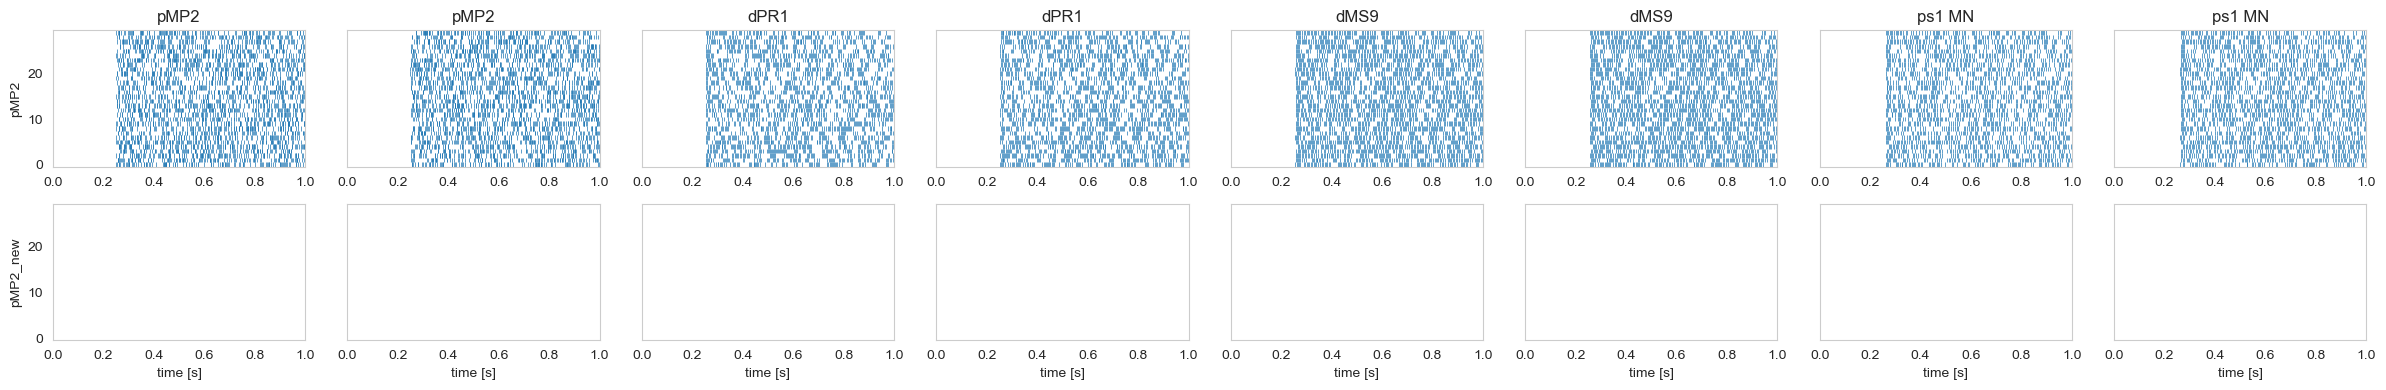

In [34]:
# raster plots
neu = pmp2 + [10267, 10300] + [10494, 10338] + [10958, 10204]
vis.plot_raster(df_spkt, neu, xlims=(0, 1), id2name=mancid_type_dict)

INFO: setting figsize to (10, 4)


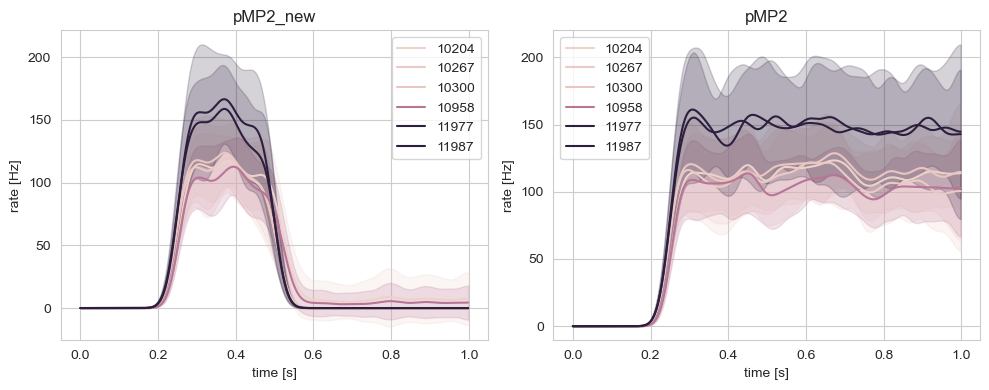

In [24]:
# firing rates
neu1 = type_mancid_dict['pMP2'] + type_mancid_dict['dPR1'] + type_mancid_dict['ps1 MN']
vis.plot_rate(df_spkt, neu1, xlims=(0, 1), id2name={})

INFO: setting figsize to (10, 4)


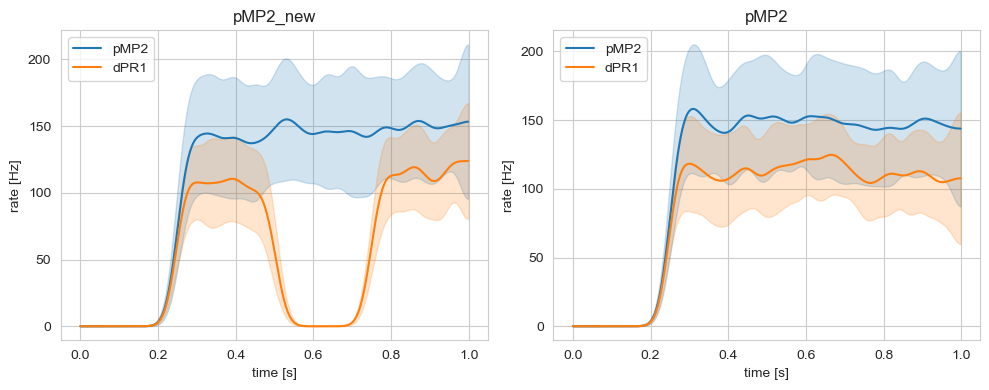

In [19]:
vis.plot_rate(df_spkt, neu1, xlims=(0, 1), id2name=mancid_type_dict)

In [33]:
import matplotlib.pyplot as plt

In [14]:
# select top 20 neurons
top20 = df_rate.sort_values(by="pMP2_new", ascending=False).head(20)
top20.rename(mancid_type_dict)

exp_name,pMP2,pMP2_new
database_id,,
IN03B024,121.033333,121.033333
IN03B024,117.533333,117.833333
pMP2,111.433333,111.666667
vPR9,110.800000,111.433333
pMP2,111.900000,109.633333
IN11A001,110.366667,109.166667
vMS12,108.133333,107.666667
IN11A001,106.100000,106.300000
vPR9,105.033333,105.200000


INFO: setting figsize to (10, 6.0)


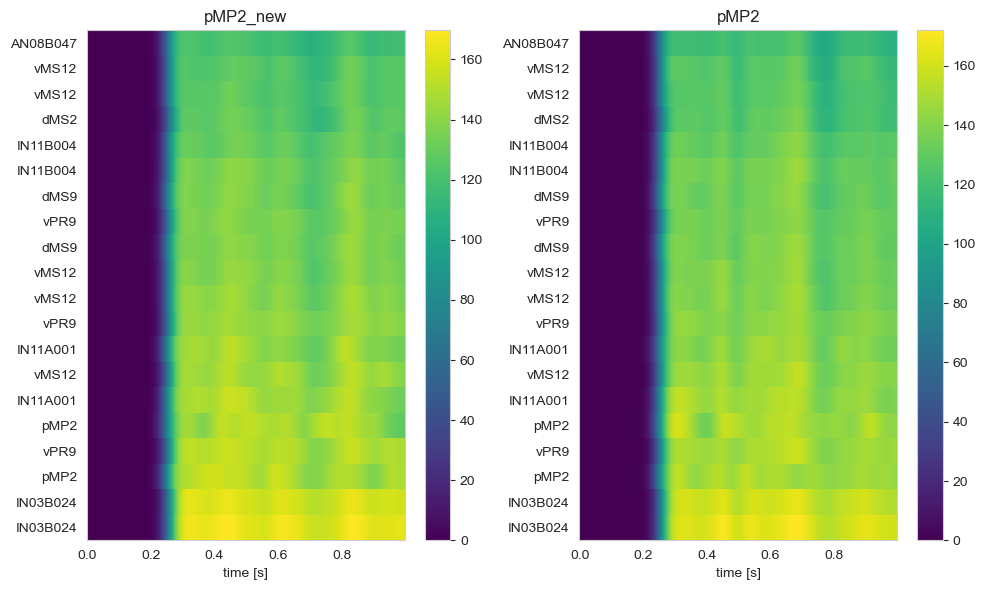

In [ ]:
# plot heatmap
vis.plot_rate_heatmap(df_spkt, top20.index, xlims=(0, 1), do_zscore=False, id2name=mancid_type_dict)

## Plots using average firing rates in `df_rate`

In [ ]:
# plot firing rate matrix
vis.firing_rate_matrix(df_rate, id2name=mancid_type_dict)

In [ ]:
# subtract P9 firing rate from all neurons
df_change = df_rate.subtract(df_rate.loc[:, "pMP2"], axis=0)

# ignore absolute changes in firing rate smaller than some threshold
df_change = df_change[(df_change.abs() >= 2).any(axis=1)]

# plot difference matrix
vis.firing_rate_matrix(df_change, rate_change=True)